In [1]:
using ModelingToolkit, DifferentialEquations, Plots
using CirculationModels

# A simple single-chamber model

![Single chamber, closed-loop, lumped parameter model of the systemic circulation and the left ventricle. The circuit equivalent formulation of the model is depicted, with the pressures of each compartment, as well as most of the mechanical parameters. The model describes three compartments: the left ventricular, arterial and venous compartments. 𝑃𝑡ℎ is the intrathoracic pressure, 𝑃𝑙𝑣 is the left ventricular pressure and 𝐸𝑙𝑣(𝑡) indicates the left ventricular elastance function.](./BjordalsbakkeModelSketch.png)


This follows Bjørdalsbakke et al.

Bjørdalsbakke, N.L., Sturdy, J.T., Hose, D.R., Hellevik, L.R., 2022. Parameter estimation for closed-loop lumped parameter models of the systemic circulation using synthetic data. Mathematical Biosciences 343, 108731. https://doi.org/10.1016/j.mbs.2021.108731

## Define the parameters

Heart rate and cycle time

In [2]:
HR = 70.58823529411765
τ = 60.0/HR

0.85

Double Hill parameters for the ventricle

In [3]:
Eₘᵢₙ = 0.03
Eₘₐₓ = 1.5
n1LV    = 1.32;
n2LV    = 21.9;
Tau1fLV = 0.303 * τ;
Tau2fLV = 0.508 * τ

0.4318

Resistances and Compliances

In [4]:
Rs = 1.11
Csa = 1.13
Csv = 11.0

11.0

Valve parameters

Aortic valve basic

In [5]:
Zao = 0.033

0.033

Mitral valve basic

In [6]:
Rmv = 0.006

0.006

Inital Pressure (mean cardiac filling pressure)

In [7]:
MCFP = 7.0

7.0

## Calculating the additional `k` parameter

The ventricle elastance is modelled as:

$$E_{l v}(t)=\left(E_{\max }-E_{\min }\right) e(t)+E_{\min }$$

where $e$ is a double-Hill function, i.e., two Hill-functions, which are multiplied by each other:

$$e(\tau)= k \times \frac{\left(\tau / \tau_1\right)^{n_1}}{1+\left(\tau / \tau_1\right)^{n_1}} \times \frac{1}{1+\left(\tau / \tau_2\right)^{n_2}}$$

$k$ is a scaling factor to assure that $e(t)$ has a maximum of $e(t)_{max} = 1$:

$$k = \max \left(\frac{\left(\tau / \tau_1\right)^{n_1}}{1+\left(\tau / \tau_1\right)^{n_1}} \times \frac{1}{1+\left(\tau / \tau_2\right)^{n_2}} \right)^{-1}$$ .

In [8]:
nstep = 1000
t = LinRange(0, τ, nstep)

kLV = 1 / maximum((t ./ Tau1fLV).^n1LV ./ (1 .+ (t ./ Tau1fLV).^n1LV) .* 1 ./ (1 .+ (t ./ Tau2fLV).^n2LV))

1.6721792928965973

## Set up the model elements

Set up time as a parameter `t`

In [9]:
@parameters t

1-element Vector{Symbolics.Num}:
 t

Heart is modelled as a single chamber (we call it `LV` for "Left Ventricle" so the model can be extended later, if required):

In [10]:
@named LV = DHChamber(V₀ = 0.0, Eₘₐₓ=Eₘₐₓ, Eₘᵢₙ=Eₘᵢₙ, n₁=n1LV, n₂=n2LV, τ = τ, τ₁=Tau1fLV, τ₂=Tau2fLV, k = kLV, Eshift=0.0, Ev=Inf)

Model LV with 4 (6) equations
States (6):
  V(t) [defaults to 2.0]
  p(t) [defaults to 0.0]
  in₊p(t) [defaults to 1.0]
  in₊q(t) [defaults to 1.0]
⋮
Parameters (11):
  V₀ [defaults to 0.0]
  Eₘᵢₙ [defaults to 0.03]
  Eₘₐₓ [defaults to 1.5]
  n₁ [defaults to 1.32]
⋮

The two valves are simple diodes with a small resistance
(resistance is needed, since perfect diodes would connect two elastances/compliances, which will lead to unstable oscillations):

In [11]:
@named AV = ResistorDiode(R=Zao)
@named MV = ResistorDiode(R=Rmv)

Model MV with 4 (6) equations
States (6):
  Δp(t) [defaults to 0.0]
  q(t) [defaults to 0.0]
  in₊p(t) [defaults to 1.0]
  in₊q(t) [defaults to 1.0]
⋮
Parameters (1):
  R [defaults to 0.006]

The main components of the circuit are 1 resistor `Rs` and two compliances for systemic arteries `Csa`,
and systemic veins `Csv` (names are arbitrary).

In [12]:
@named Rs = Resistor(R=Rs)

@named Csa = Compliance(C=Csa)
@named Csv = Compliance(C=Csv)

Model Csv with 4 (6) equations
States (6):
  V(t) [defaults to 0.0]
  p(t) [defaults to 0.0]
  in₊p(t) [defaults to 1.0]
  in₊q(t) [defaults to 1.0]
⋮
Parameters (2):
  V₀ [defaults to 0.0]
  C [defaults to 11.0]

We also need to define a base pressure level, which we use the `Ground` element for:

In [13]:
@named ground = Ground(P=0)

Model ground with 1 (2) equations
States (2):
  g₊p(t) [defaults to 1.0]
  g₊q(t) [defaults to 1.0]
Parameters (1):
  P [defaults to 0]

## Build the system

### Connections

The system is built using the `connect` function. `connect` sets up the Kirchhoff laws:

- pressures are the same in all connected branches on a connector
- sum of all flow rates at a connector is zero

The resulting set of Kirchhoff equations is stored in `circ_eqs`:

In [14]:
circ_eqs = [
    connect(LV.out, AV.in)
    connect(AV.out, Csa.in)
    connect(Csa.out, Rs.in)
    connect(Rs.out, Csv.in)
    connect(Csv.out, MV.in)
    connect(MV.out, LV.in)
]

6-element Vector{Symbolics.Equation}:
 connect(LV.out, AV.in)
 connect(AV.out, Csa.in)
 connect(Csa.out, Rs.in)
 connect(Rs.out, Csv.in)
 connect(Csv.out, MV.in)
 connect(MV.out, LV.in)

### Add the component equations

In a second step, the system of Kirchhoff equations is completed by the component equations (both ODEs and AEs), resulting in the full, overdefined ODE set `circ_model`.

_Note: we do this in two steps._

In [15]:
@named _circ_model = ODESystem(circ_eqs, t)

@named circ_model = compose(_circ_model,
                          [LV, AV, MV, Rs, Csa, Csv, ground])

Model circ_model with 25 (38) equations
States (38):
  LV₊V(t) [defaults to 2.0]
  LV₊p(t) [defaults to 0.0]
  LV₊in₊p(t) [defaults to 1.0]
  LV₊in₊q(t) [defaults to 1.0]
⋮
Parameters (19):
  LV₊V₀ [defaults to 0.0]
  LV₊Eₘᵢₙ [defaults to 0.03]
  LV₊Eₘₐₓ [defaults to 1.5]
  LV₊n₁ [defaults to 1.32]
⋮

### Simplify the ODE system

The crucial step in any acausal modelling is the sympification and reduction of the OD(A)E system to the minimal set of equations. ModelingToolkit.jl does this in the `structural_simplify` function.

In [16]:
circ_sys = structural_simplify(circ_model)

Model circ_model with 3 equations
States (3):
  LV₊p(t) [defaults to 0.0]
  Csa₊p(t) [defaults to 0.0]
  Csv₊p(t) [defaults to 0.0]
Parameters (19):
  LV₊V₀ [defaults to 0.0]
  LV₊Eₘᵢₙ [defaults to 0.03]
  LV₊Eₘₐₓ [defaults to 1.5]
  LV₊n₁ [defaults to 1.32]
⋮
Incidence matrix:3×6 SparseArrays.SparseMatrixCSC{Symbolics.Num, Int64} with 12 stored entries:
 ×  ×  ×  ×  ⋅  ⋅
 ×  ×  ×  ⋅  ×  ⋅
 ×  ×  ×  ⋅  ⋅  ×

`circ_sys` is now the minimal system of equations. In this case it consists of 3 ODEs for the three pressures.

_Note: `structural_simplify` reduces and optimises the ODE system. It is, therefore, not always obvious, which states it will use and which it will drop. We can use the `states` and `observed` function to check this. It is recommended to do this, since small changes can reorder states, observables, and parameters._

States in the system are now:

In [17]:
states(circ_sys)

3-element Vector{Any}:
 LV₊p(t)
 Csa₊p(t)
 Csv₊p(t)

Observed variables - the system will drop these from the ODE system that is solved, but it keeps all the algebraic equations needed to calculate them in the system object, as well as the `ODEProblem` and solution object - are:

In [18]:
observed(circ_sys)

35-element Vector{Symbolics.Equation}:
 LV₊out₊p(t) ~ LV₊p(t)
 LV₊in₊p(t) ~ LV₊p(t)
 AV₊in₊p(t) ~ LV₊p(t)
 MV₊out₊p(t) ~ LV₊p(t)
 AV₊out₊p(t) ~ Csa₊p(t)
 Rs₊in₊p(t) ~ Csa₊p(t)
 Csa₊out₊p(t) ~ Csa₊p(t)
 Csa₊in₊p(t) ~ Csa₊p(t)
 MV₊in₊p(t) ~ Csv₊p(t)
 Rs₊out₊p(t) ~ Csv₊p(t)
 ⋮
 Rs₊in₊q(t) ~ Csv₊in₊q(t)
 LV₊in₊q(t) ~ -Csv₊out₊q(t)
 MV₊q(t) ~ -Csv₊out₊q(t)
 MV₊out₊q(t) ~ Csv₊out₊q(t)
 MV₊in₊q(t) ~ -Csv₊out₊q(t)
 AV₊q(t) ~ Csa₊in₊q(t)
 LV₊out₊q(t) ~ -Csa₊in₊q(t)
 AV₊out₊q(t) ~ -Csa₊in₊q(t)
 AV₊in₊q(t) ~ Csa₊in₊q(t)

And the parameters (these could be reordered, so check these, too):

In [19]:
parameters(circ_sys)

19-element Vector{SymbolicUtils.Sym{Real, Base.ImmutableDict{DataType, Any}}}:
 LV₊V₀
 LV₊Eₘᵢₙ
 LV₊Eₘₐₓ
 LV₊n₁
 LV₊n₂
 LV₊τ
 LV₊τ₁
 LV₊τ₂
 LV₊k
 LV₊Eshift
 LV₊Ev
 AV₊R
 MV₊R
 Rs₊R
 Csa₊V₀
 Csa₊C
 Csv₊V₀
 Csv₊C
 ground₊P

### Define the ODE problem

First defined initial conditions `u0` and the time span for simulation:

In [20]:
u0 = [MCFP, MCFP, MCFP]

tspan = (0, 20)

(0, 20)

in this case we use the mean cardiac filling pressure as initial condition, and simulate 20 seconds.

Then we can define the problem:

In [21]:
prob = ODEProblem(circ_sys, u0, tspan)

ODEProblem with uType Vector{Float64} and tType Int64. In-place: true
timespan: (0, 20)
u0: 3-element Vector{Float64}:
 7.0
 7.0
 7.0

## Simulate

The ODE problem is now in the MTK/DifferentialEquations.jl format and we can use any DifferentialEquations.jl solver to solve it:

In [22]:
sol = solve(prob, Vern7(), reltol=1e-12, abstol=1e-12);

## Results

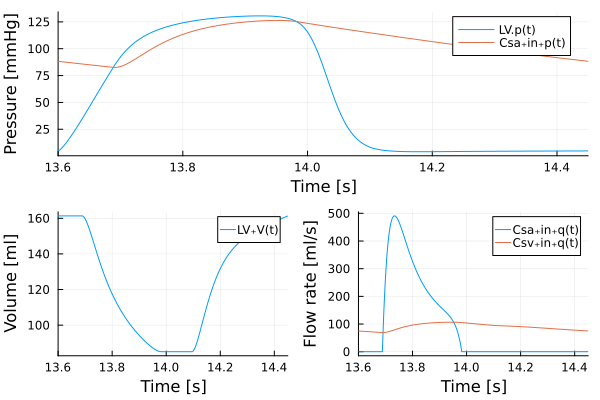

In [23]:
using Plots
using DisplayAs

p1 = plot(sol, idxs=[LV.p,  Csa.in.p], tspan=(16 * τ, 17 * τ), xlabel = "Time [s]", ylabel = "Pressure [mmHg]",  hidexaxis = nothing) # Make a line plot
p2 = plot(sol, idxs=[LV.V], tspan=(16 * τ, 17 * τ),xlabel = "Time [s]", ylabel = "Volume [ml]",  linkaxes = :all)
p3 = plot(sol, idxs=[Csa.in.q,Csv.in.q], tspan=(16 * τ, 17 * τ),xlabel = "Time [s]", ylabel = "Flow rate [ml/s]", linkaxes = :all)

img = plot(p1, p2, p3, layout=@layout([a; b c]), legend = true)

img = DisplayAs.Text(DisplayAs.PNG(img))

img

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*